In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
import scipy.cluster.hierarchy as shc
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Import/Format Data

In [2]:
data=pd.read_csv('data/patients.csv')
dataOG=pd.read_csv('data/patients.csv')
dfo=pd.read_csv('data/observations.csv')
data['BIRTHDATE']=data['BIRTHDATE'].str.replace('-', '')
data['SSN']=data['SSN'].str.replace('-', '')
data['BIRTHDATE']=data['BIRTHDATE'].astype(float)
data['SSN']=data['SSN'].astype(float)
data=data.drop(['Id','DEATHDATE','MAIDEN','DRIVERS','PASSPORT','PREFIX','FIRST','LAST','SUFFIX','BIRTHPLACE','ADDRESS','CITY','STATE','COUNTY'],axis=1)
data['MARITAL']=data['MARITAL'].fillna(0)
data['ZIP']=data['ZIP'].fillna(0)
data['MARITAL']=data['MARITAL'].replace({'M':1})
data['MARITAL']=data['MARITAL'].replace({'S':0})
data['GENDER']=data['GENDER'].replace({'M':1})
data['GENDER']=data['GENDER'].replace({'F':0})

# Set Up Observation Data Frame

In [3]:
dfm=pd.DataFrame()
dfm['PATIENT']=dataOG['Id']
dfm['Body Height']=np.nan
dfm['Body Weight']=np.nan
dfm['Body Mass Index']=np.nan
dfm['Diastolic Blood Pressure']=np.nan
dfm['Systolic Blood Pressure']=np.nan
dfm['Heart rate']=np.nan
dfm['Respiratory rate']=np.nan
dfm.head()

,PATIENT,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate
0,1d604da9-9a81-4ba9-80c2-de3375d59b40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,034e9e3b-2def-4559-bb2a-7850888ae060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10339b10-3cd1-4ac3-ac13-ec26728cb592,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8d4c4326-e9de-4f45-9a4c-f8c36bff89ae,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#DISCLAIMER:stole this bit from Justin
columns=["Body Height","Body Weight","Body Mass Index","Diastolic Blood Pressure","Systolic Blood Pressure"
         ,"Heart rate","Respiratory rate"]
patients=[]
descriptions=[]
values=[]

for index,row, in dfo [["PATIENT", "DESCRIPTION", "VALUE"]].iterrows():
    if row["DESCRIPTION"] in columns:
        for column in columns:
            if row["DESCRIPTION"]==column:
                patients.append(row["PATIENT"])
                descriptions.append(column)
                values.append(row["VALUE"])

## Populate Dataframe

In [5]:
for index, row in dfm.iterrows():
    for pat, desc, val in zip(patients, descriptions, values):
        if pat==row['PATIENT']:
            dfm.loc[dfm.PATIENT==pat,desc]=val

In [6]:
dfm.head()

,PATIENT,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate
0,1d604da9-9a81-4ba9-80c2-de3375d59b40,181.0,75.6,23.1,80.0,130.0,62.0,13.0
1,034e9e3b-2def-4559-bb2a-7850888ae060,193.3,87.8,23.5,85.0,103.0,66.0,13.0
2,10339b10-3cd1-4ac3-ac13-ec26728cb592,165.7,76.4,27.8,83.0,106.0,64.0,16.0
3,8d4c4326-e9de-4f45-9a4c-f8c36bff89ae,162.5,78.2,29.6,74.0,127.0,84.0,15.0
4,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,181.2,97.2,29.6,82.0,111.0,77.0,13.0


# Merge Patient/observation Dataframe

In [7]:
data.head()

,BIRTHDATE,SSN,MARITAL,RACE,ETHNICITY,GENDER,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
0,19890525.0,999766866.0,1,white,hispanic,1,1013.0,42.228354,-72.562951,271227.08,1334.88
1,19831114.0,999735361.0,1,white,nonhispanic,1,2143.0,42.360697,-71.126531,793946.01,3204.49
2,19920602.0,999273385.0,1,white,nonhispanic,1,1020.0,42.181642,-72.608842,574111.90,2606.40
3,19780527.0,999854926.0,1,white,nonhispanic,0,1851.0,42.636143,-71.343255,935630.30,8756.19
4,19961018.0,999607372.0,0,white,nonhispanic,1,2135.0,42.352434,-71.028610,598763.07,3772.20


In [8]:
df=pd.concat([data,dfm],axis=1)
df=df.drop(['PATIENT','SSN','LAT','LON'],axis=1)
df.head()

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate
0,19890525.0,1,white,hispanic,1,1013.0,271227.08,1334.88,181.0,75.6,23.1,80.0,130.0,62.0,13.0
1,19831114.0,1,white,nonhispanic,1,2143.0,793946.01,3204.49,193.3,87.8,23.5,85.0,103.0,66.0,13.0
2,19920602.0,1,white,nonhispanic,1,1020.0,574111.90,2606.40,165.7,76.4,27.8,83.0,106.0,64.0,16.0
3,19780527.0,1,white,nonhispanic,0,1851.0,935630.30,8756.19,162.5,78.2,29.6,74.0,127.0,84.0,15.0
4,19961018.0,0,white,nonhispanic,1,2135.0,598763.07,3772.20,181.2,97.2,29.6,82.0,111.0,77.0,13.0


In [9]:
dfcopy=df.copy()
dfcopy=dfcopy.dropna()
dfcopy=dfcopy.sample(frac=1, random_state=7896)
dfcopy.head()

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate
1030,19390401.0,1,white,nonhispanic,1,1420.0,1431684.74,10027.07,177.0,88.1,28.1,71.0,137.0,93.0,13.0
1015,19940225.0,0,white,nonhispanic,0,0.0,84681.47,9639.33,164.6,65.9,24.3,98.0,188.0,85.0,15.0
1107,19620913.0,1,white,hispanic,1,2128.0,1537244.45,4090.52,182.3,91.3,27.5,79.0,139.0,76.0,13.0
73,19540729.0,1,white,nonhispanic,0,0.0,1322856.00,12597.56,161.7,71.2,27.2,88.0,116.0,63.0,14.0
806,19170531.0,1,white,nonhispanic,0,2601.0,1600827.58,32774.56,178.3,89.5,28.2,71.0,107.0,85.0,14.0


## Encode Categories

In [10]:
enc = preprocessing.OrdinalEncoder()
X=df.iloc[:,2:4].values
enc.fit(X)

OrdinalEncoder()

In [11]:
X=enc.transform(X)
cols=['RACE','ETHNICITY']
df[cols]=X

In [12]:
df=df.dropna()
df=df.sample(frac=1, random_state=7896)
df.head()

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate
1030,19390401.0,1,4.0,1.0,1,1420.0,1431684.74,10027.07,177.0,88.1,28.1,71.0,137.0,93.0,13.0
1015,19940225.0,0,4.0,1.0,0,0.0,84681.47,9639.33,164.6,65.9,24.3,98.0,188.0,85.0,15.0
1107,19620913.0,1,4.0,0.0,1,2128.0,1537244.45,4090.52,182.3,91.3,27.5,79.0,139.0,76.0,13.0
73,19540729.0,1,4.0,1.0,0,0.0,1322856.00,12597.56,161.7,71.2,27.2,88.0,116.0,63.0,14.0
806,19170531.0,1,4.0,1.0,0,2601.0,1600827.58,32774.56,178.3,89.5,28.2,71.0,107.0,85.0,14.0


# Hierachical Clustering

## Dendrogram

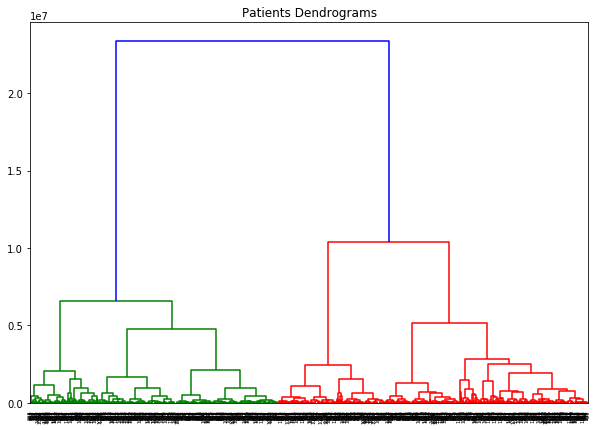

In [13]:
plt.figure(figsize=(10, 7))
plt.title("Patients Dendrograms")
dend = shc.dendrogram(shc.linkage(df, method='ward'))

## Agglomerative Clustering

In [14]:
cluster= AgglomerativeClustering(n_clusters=3, affinity='euclidean',linkage='ward')
cluster.fit_predict(df)
print(cluster.labels_)

[1 0 1 ... 1 1 0]


## Mean Shift

In [15]:
clf=MeanShift()
clf.fit(df)
labels=clf.labels_
cluster_centers=clf.cluster_centers_
dfcopy['cluster_group']=np.nan
df['cluster_group']=np.nan

In [16]:
for i in range(len(df)):
    dfcopy['cluster_group'].iloc[i]=labels[i]
    df['cluster_group'].iloc[i]=labels[i]
n_clusters_ =len(np.unique(labels))
print(n_clusters_)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


4


In [17]:
dfcopy.head()

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate,cluster_group
1030,19390401.0,1,white,nonhispanic,1,1420.0,1431684.74,10027.07,177.0,88.1,28.1,71.0,137.0,93.0,13.0,1.0
1015,19940225.0,0,white,nonhispanic,0,0.0,84681.47,9639.33,164.6,65.9,24.3,98.0,188.0,85.0,15.0,0.0
1107,19620913.0,1,white,hispanic,1,2128.0,1537244.45,4090.52,182.3,91.3,27.5,79.0,139.0,76.0,13.0,1.0
73,19540729.0,1,white,nonhispanic,0,0.0,1322856.00,12597.56,161.7,71.2,27.2,88.0,116.0,63.0,14.0,1.0
806,19170531.0,1,white,nonhispanic,0,2601.0,1600827.58,32774.56,178.3,89.5,28.2,71.0,107.0,85.0,14.0,1.0


### Analyzing Groups

In [18]:
temp0=dfcopy[dfcopy['cluster_group']==0]
len(temp0)

482

In [19]:
temp1=dfcopy[dfcopy['cluster_group']==1]
len(temp1)

402

In [20]:
temp2=dfcopy[dfcopy['cluster_group']==2]
len(temp2)

243

In [21]:
temp3=dfcopy[dfcopy['cluster_group']==3]
len(temp3)

7

#### Looking at Outlier Group

In [22]:
temp3.head(7)

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate,cluster_group
460,19130530.0,1,black,nonhispanic,1,2118.0,1521294.16,350569.24,176.3,91.2,29.3,75.0,136.0,62.0,16.0,3.0
738,19130530.0,0,black,nonhispanic,1,2128.0,1901642.45,927873.53,167.2,76.1,27.2,77.0,126.0,90.0,12.0,3.0
1000,19140906.0,0,white,nonhispanic,1,0.0,2145924.40,3559.68,181.2,92.0,28.0,81.0,123.0,92.0,14.0,3.0
449,19130530.0,0,black,nonhispanic,1,2151.0,1781146.07,178381.96,180.0,73.0,22.5,80.0,119.0,84.0,13.0,3.0
943,19170507.0,1,white,nonhispanic,1,1950.0,1845466.08,264512.97,160.1,74.6,29.1,69.0,112.0,80.0,14.0,3.0
726,19111119.0,1,white,nonhispanic,1,0.0,1776758.57,248096.56,181.2,93.5,28.5,77.0,120.0,92.0,14.0,3.0
377,19230622.0,0,white,nonhispanic,1,0.0,1689533.55,612223.87,179.0,88.6,27.7,73.0,114.0,70.0,15.0,3.0


# PCA for Data Visualization

In [23]:
pca=PCA(n_components=3)
principalComponents=pca.fit_transform(df)
principalDF = pd.DataFrame(data=principalComponents, columns =['Principal Component 1', 'Principal Component 2','Principal Component 3'])
principalDF.head()

,Principal Component 1,Principal Component 2,Principal Component 3
0,723609.072878,103505.395447,-19470.126893
1,-730284.182773,55588.239714,5483.152732
2,742652.071352,-149330.136284,-14439.653489
3,569491.058820,530.313594,-9843.755443
4,958795.768739,251839.637519,-7067.187817


In [24]:
finalDF=pd.concat([principalDF, df[['cluster_group']]],axis=1)
finalDF.head()

,Principal Component 1,Principal Component 2,Principal Component 3,cluster_group
0,723609.072878,103505.395447,-19470.126893,0.0
1,-730284.182773,55588.239714,5483.152732,2.0
2,742652.071352,-149330.136284,-14439.653489,0.0
3,569491.058820,530.313594,-9843.755443,2.0
4,958795.768739,251839.637519,-7067.187817,0.0


### 2D

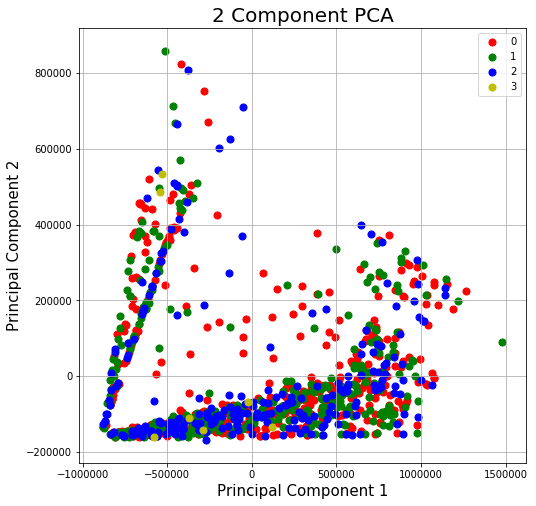

In [25]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0,1,2,3]
colors = ['r', 'g', 'b','y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDF['cluster_group'] == target
    ax.scatter(finalDF.loc[indicesToKeep, 'Principal Component 1']
               , finalDF.loc[indicesToKeep, 'Principal Component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### 3D

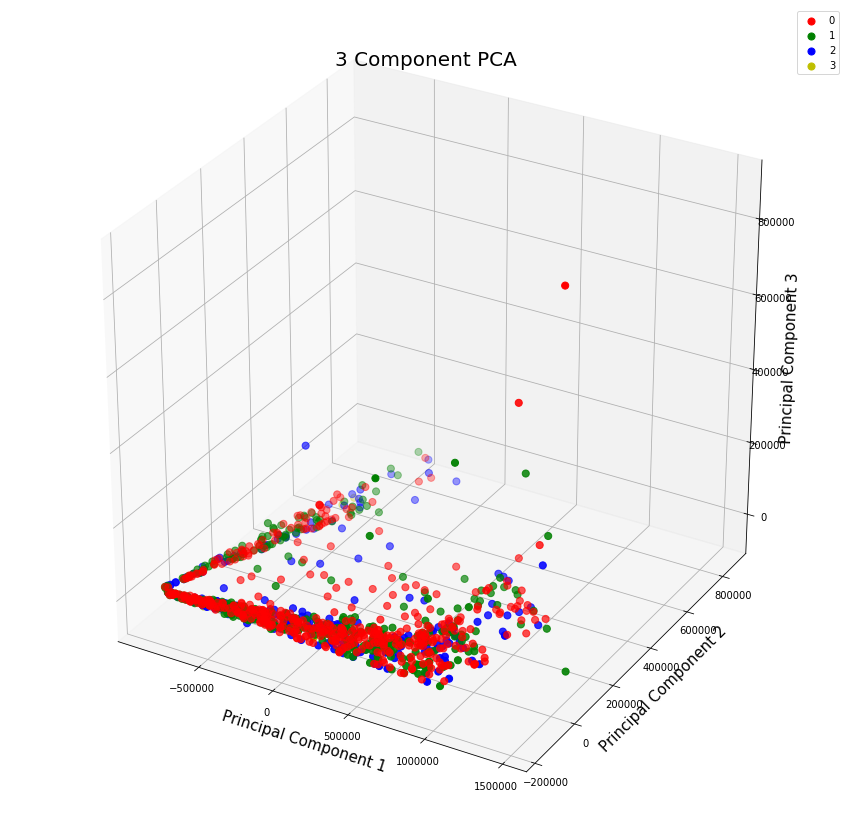

In [26]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111,projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 Component PCA', fontsize = 20)


targets = [0,1,2,3]
colors = ['r', 'g', 'b','y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDF['cluster_group'] == target
    ax.scatter(finalDF.loc[indicesToKeep, 'Principal Component 1']
               , finalDF.loc[indicesToKeep, 'Principal Component 2']
               , finalDF.loc[indicesToKeep, 'Principal Component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()